# Prepare synthetic survey data for the practicals

https://en.wikipedia.org/wiki/Geology_of_Cape_Town

http://www.scielo.org.za/pdf/sajs/v113n11-12/18.pdf

http://userpage.fu-berlin.de/geodyn/instruments/Manual_Lacoste_GDl.pdf

In [1]:
from pathlib import Path
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import verde as vd
import harmonica as hm
import boule as bl
import pyproj

In [2]:
random = np.random.default_rng(seed=0)

/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load the Southern Africa gravity data

In [3]:
data = hm.datasets.fetch_south_africa_gravity()
data = data[data.elevation > 0]
data

,latitude,longitude,elevation,gravity
43,-34.12971,18.34444,32.2,979656.12
44,-34.08833,18.36028,592.5,979508.21
45,-34.19583,18.37418,18.4,979666.46
47,-34.23972,18.40388,25.0,979671.03
48,-34.16444,18.41112,228.7,979616.11
...,...,...,...,...
14554,-17.95833,21.22500,1053.1,978182.09
14555,-17.98333,21.27500,1033.3,978183.09
14556,-17.99166,21.70833,1041.8,978182.69
14557,-17.95833,21.85000,1033.3,978193.18


/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


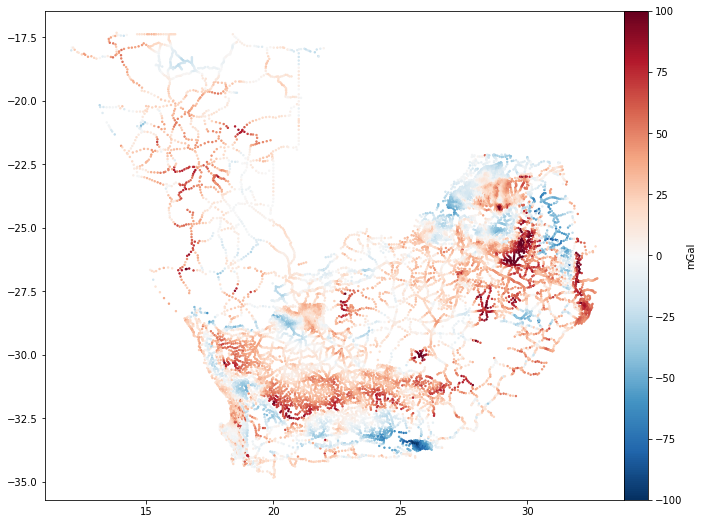

In [4]:
plt.figure(figsize=(14, 9))
plt.scatter(data.longitude, data.latitude, c=data.gravity - bl.WGS84.normal_gravity(data.latitude, data.elevation), s=2, vmin=-100, vmax=100, cmap="RdBu_r")
plt.axis("scaled")
plt.colorbar(pad=0, label="mGal")

## Select a smaller survey area around Cape Town

In [5]:
region = [18, 19, -35, -33.65]
projection = pyproj.Proj("+proj=utm +zone=34H +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
survey = data.loc[vd.inside((data.longitude, data.latitude), region) & (data.elevation < 300)].copy().reset_index(drop=True)
survey["station_id"] = np.arange(survey.shape[0])
survey["easting"], survey["northing"] = (np.round(i, decimals=2) for i in projection(survey.longitude.values, survey.latitude.values))
survey

,latitude,longitude,elevation,gravity,station_id,easting,northing
0,-34.12971,18.34444,32.2,979656.12,0,255105.43,6220276.33
1,-34.19583,18.37418,18.4,979666.46,1,258037.64,6213013.01
2,-34.23972,18.40388,25.0,979671.03,2,260899.25,6208214.71
3,-34.16444,18.41112,228.7,979616.11,3,261353.99,6216582.03
4,-34.29778,18.42557,104.0,979662.74,4,263060.44,6201825.21
...,...,...,...,...,...,...,...
86,-33.68611,18.87862,183.2,979563.51,86,303360.10,6270627.01
87,-33.75389,18.88222,193.8,979565.46,87,303848.17,6263116.91
88,-33.92944,18.89111,199.2,979581.57,88,305070.98,6243664.61
89,-33.79388,18.95612,144.1,979577.13,89,310782.02,6258820.18


/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


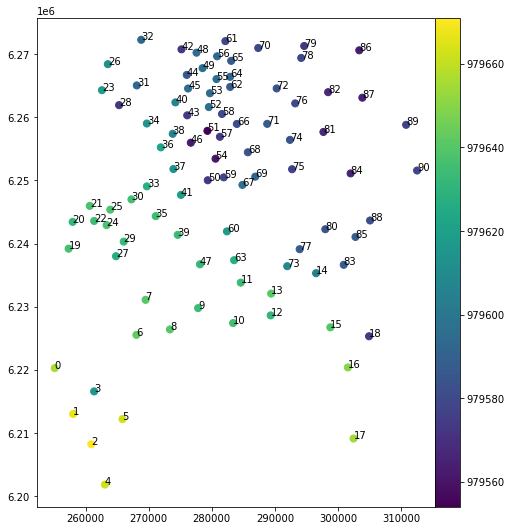

In [6]:
plt.figure(figsize=(14, 9))
ax = plt.subplot(111)
tmp = ax.scatter(survey.easting, survey.northing, c=survey.gravity, s=50)
for i in range(survey.shape[0]):
    ax.text(survey.easting[i], survey.northing[i], str(survey.station_id[i]))
plt.axis("scaled")
plt.colorbar(tmp, pad=0)

## Split this up into daily surveys

Each of these will represent a day in the field, starting and ending at a base station for drift correction.

In [7]:
base = 0
base_gravity = survey.gravity[base]
# Made up number for the reading scaling
nsurveys = 5
base_readings = random.uniform(2550, 2580, size=nsurveys)
survey_stations = [np.concatenate([[base], section, [base]]) for section in np.array_split(survey.station_id[1:], nsurveys)]
survey_stations

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18,  0]),
 array([ 0, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36,  0]),
 array([ 0, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
        53, 54,  0]),
 array([ 0, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
        71, 72,  0]),
 array([ 0, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,
        89, 90,  0])]

In [8]:
surveys = [survey.iloc[stations].copy().reset_index(drop=True) for stations in survey_stations]
surveys[-1]

,latitude,longitude,elevation,gravity,station_id,easting,northing
0,-34.12971,18.34444,32.2,979656.12,0,255105.43,6220276.33
1,-33.99222,18.74750,113.2,979608.33,73,291947.29,6236419.51
2,-33.81194,18.75694,133.0,979583.90,74,292382.56,6256433.25
3,-33.85390,18.75945,179.4,979576.22,75,292716.30,6251784.63
4,-33.75999,18.76723,137.1,979579.84,76,293210.26,6262215.56
5,-33.96832,18.76944,177.1,979586.88,77,293916.47,6239114.60
6,-33.69528,18.77917,118.2,979579.22,78,294161.78,6269416.14
7,-33.67833,18.78471,134.1,979573.13,79,294635.02,6271307.01
8,-33.94057,18.81416,170.3,979584.20,80,297983.35,6242281.32
9,-33.80167,18.81444,205.9,979567.13,81,297681.57,6257686.79


/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


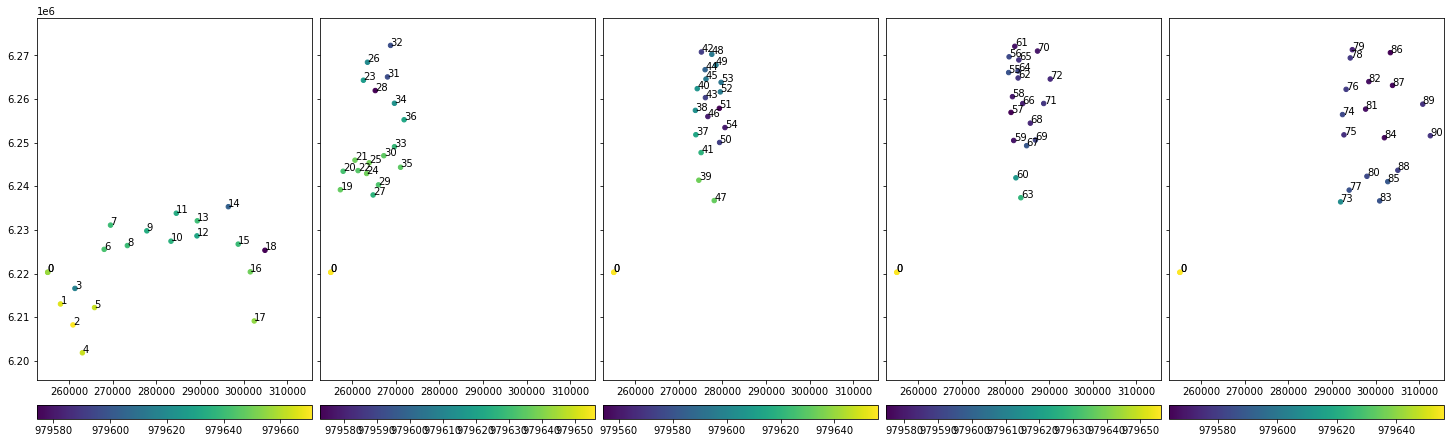

In [9]:
fig, axes = plt.subplots(1, len(surveys), figsize=(20, 7), sharey=True)
for s, ax in zip(surveys, axes):
    tmp = ax.scatter(s.easting, s.northing, c=s.gravity, s=20)
    for i in range(s.shape[0]):
        ax.text(s.easting.iloc[i], s.northing.iloc[i], str(s.station_id.iloc[i]))
    ax.set_aspect("equal")
    ax.set_xlim(survey.easting.min()*0.99, survey.easting.max()*1.01)
    ax.set_ylim(survey.northing.min()*0.999, survey.northing.max()*1.001)
    plt.colorbar(tmp, pad=0.05, ax=ax, orientation="horizontal")
plt.tight_layout(pad=0)

## Convert the gravity values to relative readings

Subtract from the base station gravity and add a factor so that it's around 2500 (rough range for latitude of -30). The factor should vary from day to day by a small factor.

In [10]:
for s, base_reading in zip(surveys, base_readings):
    s["reading_mgal"] = s.gravity - base_gravity + base_reading
surveys[-1]

,latitude,longitude,elevation,gravity,station_id,easting,northing,reading_mgal
0,-34.12971,18.34444,32.2,979656.12,0,255105.43,6220276.33,2574.398107
1,-33.99222,18.74750,113.2,979608.33,73,291947.29,6236419.51,2526.608107
2,-33.81194,18.75694,133.0,979583.90,74,292382.56,6256433.25,2502.178107
3,-33.85390,18.75945,179.4,979576.22,75,292716.30,6251784.63,2494.498107
4,-33.75999,18.76723,137.1,979579.84,76,293210.26,6262215.56,2498.118107
5,-33.96832,18.76944,177.1,979586.88,77,293916.47,6239114.60,2505.158107
6,-33.69528,18.77917,118.2,979579.22,78,294161.78,6269416.14,2497.498107
7,-33.67833,18.78471,134.1,979573.13,79,294635.02,6271307.01,2491.408107
8,-33.94057,18.81416,170.3,979584.20,80,297983.35,6242281.32,2502.478107
9,-33.80167,18.81444,205.9,979567.13,81,297681.57,6257686.79,2485.408107


/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


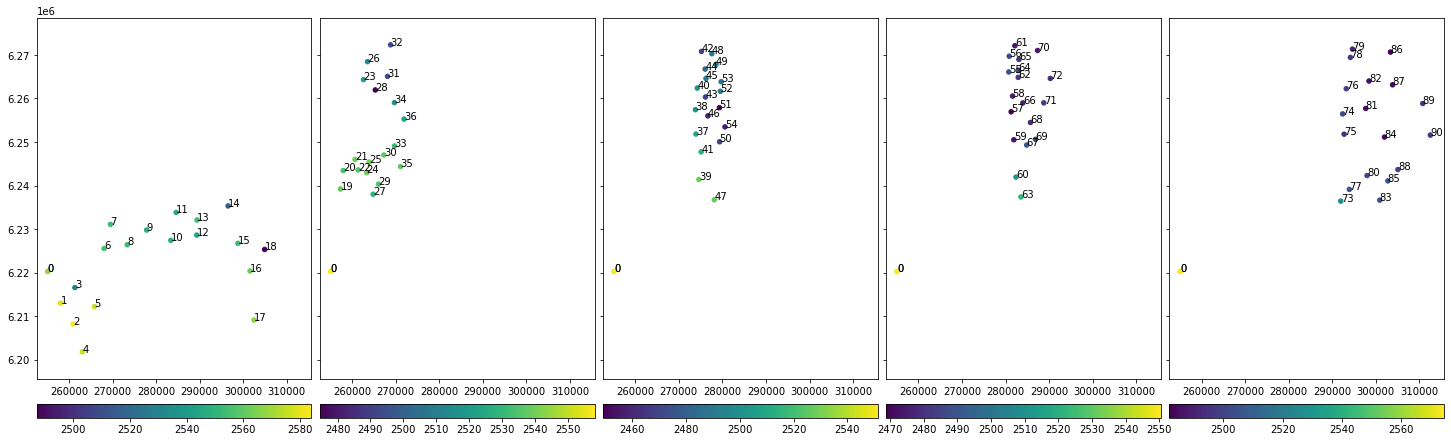

In [11]:
fig, axes = plt.subplots(1, len(surveys), figsize=(20, 7), sharey=True)
for s, ax in zip(surveys, axes):
    tmp = ax.scatter(s.easting, s.northing, c=s.reading_mgal, s=20)
    for i in range(s.shape[0]):
        ax.text(s.easting.iloc[i], s.northing.iloc[i], str(s.station_id.iloc[i]))
    ax.set_aspect("equal")
    ax.set_xlim(survey.easting.min()*0.99, survey.easting.max()*1.01)
    ax.set_ylim(survey.northing.min()*0.999, survey.northing.max()*1.001)
    plt.colorbar(tmp, pad=0.05, ax=ax, orientation="horizontal")
plt.tight_layout(pad=0)

## Convert readings from mGal to L&G gravimeter scale divisions


Use a conversion table for the gravimeter. 

In [12]:
conversion = pd.read_csv("../data/gravimeter-scaling.csv", index_col="counter_reading")
conversion

,value_mgal,interval_factor
counter_reading,,
0,0.00,1.00636
100,100.64,1.00621
200,201.26,1.00609
300,301.87,1.00597
400,402.46,1.00588
...,...,...
6600,6632.04,1.00154
6700,6732.20,1.00123
6800,6832.32,1.00089


In [13]:
for s in surveys:
    interval = np.floor(s.reading_mgal / 100).astype("int") * 100
    conv = conversion.loc[interval]
    s["reading_nodrift"] = interval + (s.reading_mgal - conv.value_mgal.values) / conv.interval_factor.values
surveys[-1]

/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,latitude,longitude,elevation,gravity,station_id,easting,northing,reading_mgal,reading_nodrift
0,-34.12971,18.34444,32.2,979656.12,0,255105.43,6220276.33,2574.398107,2560.339515
1,-33.99222,18.74750,113.2,979608.33,73,291947.29,6236419.51,2526.608107,2512.800520
2,-33.81194,18.75694,133.0,979583.90,74,292382.56,6256433.25,2502.178107,2488.498833
3,-33.85390,18.75945,179.4,979576.22,75,292716.30,6251784.63,2494.498107,2480.853626
4,-33.75999,18.76723,137.1,979579.84,76,293210.26,6262215.56,2498.118107,2484.454720
5,-33.96832,18.76944,177.1,979586.88,77,293916.47,6239114.60,2505.158107,2491.463182
6,-33.69528,18.77917,118.2,979579.22,78,294161.78,6269416.14,2497.498107,2483.837958
7,-33.67833,18.78471,134.1,979573.13,79,294635.02,6271307.01,2491.408107,2477.779763
8,-33.94057,18.81416,170.3,979584.20,80,297983.35,6242281.32,2502.478107,2488.797258
9,-33.80167,18.81444,205.9,979567.13,81,297681.57,6257686.79,2485.408107,2471.811099


## Add an acquisiton time to the survey

Record time as ellapsed minutes since the first measurement.

In [14]:
for s in surveys:
    distance = np.hypot(s.easting.values[1:] - s.easting.values[:-1], s.northing.values[1:] - s.northing.values[:-1]) * 1e-3
    # Randomize the velocity between sites to make things less uniform
    velocity = random.uniform(low=40, high=60, size=distance.size)
    travel_time = np.concatenate([[0], np.round((distance / velocity) * 60, decimals=0)])
    s["time_minutes"] = np.cumsum(travel_time)
surveys[-1]

/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,latitude,longitude,elevation,gravity,station_id,easting,northing,reading_mgal,reading_nodrift,time_minutes
0,-34.12971,18.34444,32.2,979656.12,0,255105.43,6220276.33,2574.398107,2560.339515,0.0
1,-33.99222,18.74750,113.2,979608.33,73,291947.29,6236419.51,2526.608107,2512.800520,48.0
2,-33.81194,18.75694,133.0,979583.90,74,292382.56,6256433.25,2502.178107,2488.498833,72.0
3,-33.85390,18.75945,179.4,979576.22,75,292716.30,6251784.63,2494.498107,2480.853626,77.0
4,-33.75999,18.76723,137.1,979579.84,76,293210.26,6262215.56,2498.118107,2484.454720,90.0
5,-33.96832,18.76944,177.1,979586.88,77,293916.47,6239114.60,2505.158107,2491.463182,115.0
6,-33.69528,18.77917,118.2,979579.22,78,294161.78,6269416.14,2497.498107,2483.837958,149.0
7,-33.67833,18.78471,134.1,979573.13,79,294635.02,6271307.01,2491.408107,2477.779763,151.0
8,-33.94057,18.81416,170.3,979584.20,80,297983.35,6242281.32,2502.478107,2488.797258,192.0
9,-33.80167,18.81444,205.9,979567.13,81,297681.57,6257686.79,2485.408107,2471.811099,209.0


## Apply fake drift correction to readings

Generate a slightly different one for each day.

In [15]:
s = surveys[0]

/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
for s in surveys:
    drift = np.round(random.uniform(-0.01, -0.05), decimals=2)
    s["reading"] = np.round(s.reading_nodrift + drift * s.time_minutes, decimals=2)
    assert np.allclose(drift, (s.reading.iloc[-1] - s.reading.iloc[0]) / s.time_minutes.iloc[-1])
surveys[-1]

,latitude,longitude,elevation,gravity,station_id,easting,northing,reading_mgal,reading_nodrift,time_minutes,reading
0,-34.12971,18.34444,32.2,979656.12,0,255105.43,6220276.33,2574.398107,2560.339515,0.0,2560.34
1,-33.99222,18.74750,113.2,979608.33,73,291947.29,6236419.51,2526.608107,2512.800520,48.0,2511.84
2,-33.81194,18.75694,133.0,979583.90,74,292382.56,6256433.25,2502.178107,2488.498833,72.0,2487.06
3,-33.85390,18.75945,179.4,979576.22,75,292716.30,6251784.63,2494.498107,2480.853626,77.0,2479.31
4,-33.75999,18.76723,137.1,979579.84,76,293210.26,6262215.56,2498.118107,2484.454720,90.0,2482.65
5,-33.96832,18.76944,177.1,979586.88,77,293916.47,6239114.60,2505.158107,2491.463182,115.0,2489.16
6,-33.69528,18.77917,118.2,979579.22,78,294161.78,6269416.14,2497.498107,2483.837958,149.0,2480.86
7,-33.67833,18.78471,134.1,979573.13,79,294635.02,6271307.01,2491.408107,2477.779763,151.0,2474.76
8,-33.94057,18.81416,170.3,979584.20,80,297983.35,6242281.32,2502.478107,2488.797258,192.0,2484.96
9,-33.80167,18.81444,205.9,979567.13,81,297681.57,6257686.79,2485.408107,2471.811099,209.0,2467.63


## Save all surveys 

Dump all of them to CSV files and make a zip archive with them all.

In [17]:
output_folder = Path("..") / "data" / "cape-town-surveys"
output_folder.mkdir(parents=True, exist_ok=True)
for junk in output_folder.glob(".*"):
    print(junk)
    shutil.rmtree(junk) 

/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
for i, s in enumerate(surveys):
    s.to_csv(
        output_folder / f"cape-town-gravity-day-{i + 1}.csv", 
        index=False, 
        columns="station_id longitude latitude easting northing elevation time_minutes reading".split(),
    
    )

In [19]:
#shutil.make_archive(base_name=str(output_folder), format="zip", base_dir=output_folder.parts[-1], root_dir=output_folder.parent)

## Save the absolute data as well

We'll use this for the second practical where we calculate disturbances. It will also serve as a reference for students to check that they did things correctly.

In [20]:
survey.to_csv(
    Path("..") / "data" / "cape-town-survey-absolute.csv", 
    index=False,
    columns="longitude latitude easting northing elevation gravity".split(),
)